In [1]:
!date

Mon Feb 21 14:57:41 PST 2022


In [2]:
import altair
import beanmachine.ppl as bm
import numpy as np
import pandas as pd
import sklearn.model_selection
import torch
import torch.distributions as dist
from torch import tensor


In [3]:
torch.manual_seed(12)

$$
\begin{align}
y & \sim \mathcal{N}(\beta_0 + \beta_1 x, \sigma) \\
\beta_0 & \sim \mathcal{N}(0, 10) \\
\beta_1 & \sim \mathcal{N}(0, 10) \\
\sigma & \sim \mathrm{Gamma}(1, 1) \\
\end{align}

In [5]:
altair.Chart(
    pd.DataFrame().assign(
        sigma=lambda df: torch.arange(0, 2, 0.01),
        density=lambda df: dist.Gamma(1, 1).log_prob(df["sigma"]).exp(),
    )
).mark_line().encode(x="sigma", y="density").interactive()


alt.Chart(...)

In [6]:
@bm.random_variable
def beta_0() -> bm.RVIdentifier:
    return dist.Normal(0, 10)


@bm.random_variable
def beta_1() -> bm.RVIdentifier:
    return dist.Normal(0, 10)


@bm.random_variable
def sigma() -> bm.RVIdentifier:
    return dist.Gamma(1, 1)


@bm.random_variable
def y(X: torch.Tensor) -> bm.RVIdentifier:
    return dist.Normal(beta_0() + beta_1() * X, sigma())

In [7]:
N = 200

X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_0 = 5.
true_beta_1 = 2.
true_sigma = 1.
Y = dist.Normal(true_beta_0 + true_beta_1 * X, true_sigma).sample()

In [15]:
altair.Chart(pd.DataFrame({"X": X.squeeze(), "Y": Y.squeeze()})).mark_point().encode(x="X", y="Y")

alt.Chart(...)

In [16]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

In [17]:
observations = {y(X_train): Y_train}

In [24]:
num_samples = 2000
num_chains = 4

In [25]:
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=num_samples,
    num_chains=num_chains,
)


Samples collected: 100%|██████████| 2000/2000 [00:02<00:00, 718.42it/s]


In [26]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.059507,0.282079,4.867336,5.070655,5.259278,1.009590,398.169250
beta_1()[],1.823644,0.227528,1.177521,1.846789,2.099892,1.023499,134.252411
sigma()[],1.084002,0.196724,0.942185,1.067238,1.331930,1.006060,283.387482


In [85]:
df_samples = (
    pd.DataFrame(samples_mh[beta_0()].T)
    .assign(iteration=np.arange(num_samples))
    .melt(id_vars="iteration", var_name="chain", value_name="beta_0")
)


In [86]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iteration  8000 non-null   int64  
 1   chain      8000 non-null   object 
 2   beta_0     8000 non-null   float32
dtypes: float32(1), int64(1), object(1)
memory usage: 156.4+ KB


In [87]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 100].iloc[::5]
).mark_line().encode(
    altair.X("iteration"),
    altair.Y("beta_0", scale=altair.Scale(zero=False)),
    altair.Color("chain:N"),
)


alt.Chart(...)

In [88]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 100].iloc[::5]
).transform_density(
    density="beta_0",
    bandwidth=0.1,
    groupby=["chain"],
    extent=[4.5, 5.5],
    counts=True,
    steps=50,
).mark_line().encode(
    altair.X("value:Q", title="beta_0"), altair.Y("density:Q"), altair.Color("chain:N")
) + altair.Chart().mark_rule(
    size=3
).encode(
    x=altair.datum(true_beta_0)
)


alt.LayerChart(...)

In [89]:
df_samples = (
    pd.DataFrame(samples_mh[beta_1()].T)
    .assign(iteration=np.arange(num_samples))
    .melt(id_vars="iteration", var_name="chain", value_name="beta_1")
)

In [90]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 200].iloc[::5]
).mark_line().encode(
    altair.X("iteration"),
    altair.Y("beta_1", scale=altair.Scale(zero=False)),
    altair.Color("chain:N"),
)

alt.Chart(...)

In [91]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 200].iloc[::5]
).transform_density(
    density="beta_1",
    bandwidth=0.1,
    groupby=["chain"],
    extent=[1.5, 2.5],
    counts=True,
    steps=50,
).mark_line().encode(
    altair.X("value:Q", title="beta_1"), altair.Y("density:Q"), altair.Color("chain:N")
) + altair.Chart().mark_rule(
    size=3
).encode(
    x=altair.datum(true_beta_1)
)

alt.LayerChart(...)

In [92]:
df_samples = (
    pd.DataFrame(samples_mh[sigma()].T)
    .assign(iteration=np.arange(num_samples))
    .melt(id_vars="iteration", var_name="chain", value_name="sigma")
)

In [93]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 200].iloc[::5]
).mark_line().encode(
    altair.X("iteration"),
    altair.Y("sigma", scale=altair.Scale(zero=False)),
    altair.Color("chain:N"),
)

alt.Chart(...)

In [94]:
altair.Chart(
    df_samples.loc[lambda df: df["iteration"] >= 200].iloc[::5]
).transform_density(
    density="sigma",
    bandwidth=0.1,
    groupby=["chain"],
    extent=[0.5, 1.5],
    counts=True,
    steps=50,
).mark_line().encode(
    altair.X("value:Q", title="sigma"), altair.Y("density:Q"), altair.Color("chain:N")
) + altair.Chart().mark_rule(
    size=3
).encode(
    x=altair.datum(true_sigma)
)

alt.LayerChart(...)

# BMGInference

In [95]:
from beanmachine.ppl.inference.bmg_inference import BMGInference

In [96]:
samples_nmc = BMGInference().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

In [101]:
bm.Diagnostics(samples_nmc).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.062854,0.085971,4.891837,5.063254,5.231353,0.999952,6396.521484
beta_1()[],1.858510,0.087241,1.695389,1.856812,2.026630,0.999583,6821.268066
sigma()[],1.061032,0.063390,0.946993,1.058035,1.193104,1.000067,2921.326904


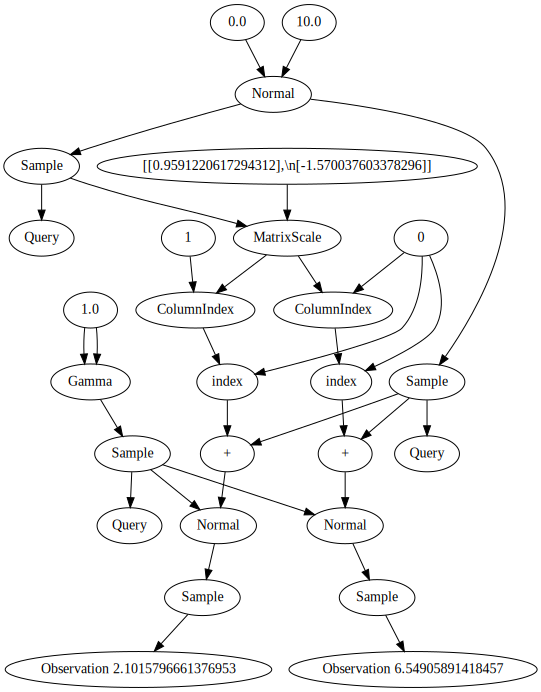

In [133]:
BMGInference().to_graphviz(
    queries=[beta_0(), beta_1(), sigma()], observations={y(X_train[:2]): Y_train[:2]}
)
